# **Peru Project**- Replication Project

---

We are a group of 5 people. Group participants: 
1. Syed Shahvaiz Ahmed 18-756-635
2. Georgios Anagnostou 20-741-260
3. Vasiliki Arpatzoglou 18-747-980
4. Santiago Cepeda 12-741-385
5. Alex Wolf 12-526-216


## Introduction
This project tries to replicate the paper from R. Hanna and B. A. Olken: "Universal basic incomes versus targeted transfers: Anti-poverty programs in developing countries."

The replication process was conducted in the same manner as in the paper. Thus, splitting the data according to the "training" attribute on the dataset. We also used imputation to fill missing values in the dataset.

We then used different models to predict whether or not a household should receive benefits. Last but not least, we replicated Figure 5 with our CRRA-utility function.


## Uploading Relevant Libraries
In this cell we upload the relevant libraries needed for the below cells.




In [ ]:
%matplotlib inline
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

# General math, csv and plotting modules.
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

# Widget and formatting modules
import ipywidgets
from ipywidgets import interact, interactive, interact_manual
import pylab
import seaborn as sns
pylab.rcParams['figure.figsize'] = (10, 5)

# Visualization Libraries
import io
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots
from matplotlib.pyplot import figure

# Loading the required libraries 
from fancyimpute import IterativeImputer as MICE
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import cohen_kappa_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
import xgboost as xgb
import lightgbm as lgb

# Avoiding warnings
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm, skew #for some statistics
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting Path
Setting the path for the data file and reading the csv as pandas Data Frame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/peru_matlab_export_full.csv')

In [ ]:
df.shape

(46305, 81)

The dataframe has **46305** rows and **81** columns. We have **73** variables (look at the appendix https://www.aeaweb.org/content/file?id=8344). The other 8 variables are related to previous matlab encodings and OLS estimators, which we do not need in this step. 

We want to **regress monthly household per-capita consumption** on the 72 actual indicator variables used in each country’s respective proxy-means test formula.

In [ ]:
df.head(5)

,lnpercapitaconsumption,d_fuel_other,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_other,d_water_river,d_water_well,d_water_truck,d_water_pylon,d_water_outside,d_water_inside,d_drain_none,d_drain_river,d_drain_cesspool,d_drain_septic,d_drain_outside,d_drain_inside,d_wall_other,d_wall_woodmat,d_wall_stonemud,d_wall_quincha,d_wall_tapia,d_wall_adobe,d_wall_stonecement,d_wall_brickcement,d_roof_other,d_roof_straw,d_roof_mat,d_roof_platecane,d_roof_tile,d_roof_wood,d_roof_concrete,d_floor_other,d_floor_earth,d_floor_cement,d_floor_wood,...,d_floor_sheets,d_floor_parquet,d_electricity,d_telephone,d_h_educ_none,d_h_educ_pre,d_h_educ_prim,d_h_educ_sec,d_h_educ_higher_nouni,d_h_educ_higher_uni,d_h_educ_post,d_max_educ_none,d_max_educ_prim,d_max_educ_sec,d_max_educ_higher_nouni,d_max_educ_higher_uni,d_insurance_0,d_insurance_1,d_insurance_2,d_insurance_3,d_insurance_4plus,d_crowd_lessthan1,d_crowd_1to2,d_crowd_2to4,d_crowd_4to6,d_crowd_6plus,d_lux_0,d_lux_1,d_lux_2,d_lux_3,d_lux_4,d_lux_5,training,percapitaconsumption,poor,h_hhsize,id_for_matlab,hhid,lncaphat_OLS,percapitahat_OLS
0,5.352,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.000,0.000,0,0,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1,0,0,0,0,1,0,0,0,0,1.000,0.000,0.000,0.000,0.000,1,0,0,0,0,0,0,211.000,0,1,1,233710511,5.246,284.424
1,5.769,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,1,0,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0,0,1,0,0,0,0,0,1,0,0.000,1.000,0.000,0.000,0.000,0,0,0,1,0,0,0,320.139,0,3,2,295508011,6.129,522.884
2,5.968,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,1,1,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0,0,0,0,1,0,0,0,0,1,1.000,0.000,0.000,0.000,0.000,0,0,0,1,0,0,0,390.832,0,4,3,257600211,6.666,878.496
3,5.655,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,1,1,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0,0,1,0,0,1,0,0,0,0,0.000,0.000,1.000,0.000,0.000,1,0,0,0,0,0,0,285.602,1,9,4,198104311,6.088,567.471
4,4.771,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,0,0,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0,0,1,0,0,0,0,0,0,1,0.000,1.000,0.000,0.000,0.000,1,0,0,0,0,0,0,118.071,1,8,5,24805311,5.008,115.493


## Train Test Split

We split to train and test data according to the training column. We divide the testing and training data exactly as was mentioned on project description. If training number is 1 we keep it in the training set and if the training number is 0 we keep it in the test set. 

We directly keep as response variable the *log-transformed* capital consumption. 

In [ ]:
train_data = df.loc[lambda df: df['training'] > 0, :]
train_data = train_data.iloc[:,:73]


In [ ]:
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]
X_train.shape

(23153, 72)

In [ ]:
test_data = df.loc[lambda df: df['training'] == 0, :]
comparative_metric = test_data['lncaphat_OLS'] # The actual y's in the test_data I believe.
test_data = test_data.iloc[:,:73]

In [ ]:
X_test = test_data.iloc[:,1:]
X_test.shape

(23152, 72)

## Imputation to fill missing values

This section is where we used a MICE imputer to impute the missing values in the dataset

In [ ]:
merged_set = pd.concat([X_train, X_test], sort = False)
merged_set.shape

(46305, 72)

In [ ]:
# Imputing the missing values in the whole dataset
merged_set_Imp = MICE().fit_transform(merged_set)

In [ ]:
merged_set_Imp = pd.DataFrame(merged_set_Imp)
merged_set_Imp.columns = X_test.columns.values # renaming columns

In [ ]:
# Separating the train set
X_train_Imp = merged_set_Imp.iloc[:len(X_train)]
X_train.shape

(23153, 72)

In [ ]:
# Separating the test set
X_test_Imp = merged_set_Imp.iloc[len(X_train):]
X_test_Imp.shape

(23152, 72)

## Models

This is where we define various machine learning models to get the relevant predictions. Since we know that the data distribution needs to be learned and at the very start we are not sure as to which model performs the best. In order to find that out, we tested the models mentioned below:

1. Lasso
2. Elastic Net
3. Kernel Ridge Regression
4. Gradient Boost (GB)
5. XGBoost (XGB)
6. Light Gradient Boost (LGB)

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

lasso = make_pipeline(StandardScaler(), Lasso(alpha =0.0005, random_state=1))

ENet = make_pipeline(StandardScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel="polynomial", degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

We tested all the models separately and found out that GBoost, XGBoost, Gradient Boost performs the best. But we still were not satisfied with their individual performance so we coded an ensemble learner which basically takes the average prediction of all the three models and it turns out that it performed much better than any singular model.

## Stacked Model

In this class, each model is separately trained and predictions are averaged of all base models. 

In [ ]:
class Stackedmodels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # Original models used for fitting data
    def fit(self, X_train, Y_train):
        self.models_ = [clone(x) for x in self.models]
        # Train specified models
        for model in self.models_:
            model.fit(X_train, Y_train)
        return self
    
    # Predict on test data and take average of models
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [ ]:
# Validation function
n_folds = 5
# Spits the rmse of the model
def rmsle_cv(model, x_train, y_train):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Running the Model

In [ ]:
# Model list
model_list = [lasso, model_lgb, ENet, KRR, GBoost, model_xgb]
model_name = ["lasso", "model_lgb", "ENet", "KRR", "GBoost", "model_xgb"]

# Model fit
averaged_models = Stackedmodels(models = (model_lgb, GBoost, model_xgb))
averaged_models.fit(X_train_Imp, y_train)

Stackedmodels(models=(LGBMRegressor(bagging_fraction=0.8, bagging_freq=5,
                                    bagging_seed=9, boosting_type='gbdt',
                                    class_weight=None, colsample_bytree=1.0,
                                    feature_fraction=0.2319,
                                    feature_fraction_seed=9,
                                    importance_type='split', learning_rate=0.05,
                                    max_bin=55, max_depth=-1,
                                    min_child_samples=20,
                                    min_child_weight=0.001, min_data_in_leaf=6,
                                    min_split_gain=0.0,
                                    min_su...
                                   colsample_bylevel=1, colsample_bynode=1,
                                   colsample_bytree=0.4603, gamma=0.0468,
                                   importance_type='gain', learning_rate=0.05,
                                   max_de

In [ ]:
X_test_Imp.columns

Index(['d_fuel_other', 'd_fuel_wood', 'd_fuel_coal', 'd_fuel_kerosene',
       'd_fuel_gas', 'd_fuel_electric', 'd_fuel_none', 'd_water_other',
       'd_water_river', 'd_water_well', 'd_water_truck', 'd_water_pylon',
       'd_water_outside', 'd_water_inside', 'd_drain_none', 'd_drain_river',
       'd_drain_cesspool', 'd_drain_septic', 'd_drain_outside',
       'd_drain_inside', 'd_wall_other', 'd_wall_woodmat', 'd_wall_stonemud',
       'd_wall_quincha', 'd_wall_tapia', 'd_wall_adobe', 'd_wall_stonecement',
       'd_wall_brickcement', 'd_roof_other', 'd_roof_straw', 'd_roof_mat',
       'd_roof_platecane', 'd_roof_tile', 'd_roof_wood', 'd_roof_concrete',
       'd_floor_other', 'd_floor_earth', 'd_floor_cement', 'd_floor_wood',
       'd_floor_tile', 'd_floor_sheets', 'd_floor_parquet', 'd_electricity',
       'd_telephone', 'd_h_educ_none', 'd_h_educ_pre', 'd_h_educ_prim',
       'd_h_educ_sec', 'd_h_educ_higher_nouni', 'd_h_educ_higher_uni',
       'd_h_educ_post', 'd_max_educ_no

In [ ]:
# Getting the predictions 
y_pred = averaged_models.predict(X_test_Imp)
len(y_pred)

23152

In [ ]:
# Getting the R square of the model
averaged_models.score(X_train_Imp, y_train)

0.7011171547590656

In [ ]:
# Making a dataframe
bingo_df = pd.concat([comparative_metric, pd.Series(y_pred).rename('y_pred')], axis=1, sort = False)
bingo_df = bingo_df[bingo_df['lncaphat_OLS'].notna()] # removing rows which don't report any values
bingo_df

,lncaphat_OLS,y_pred
0,5.246,5.228
1,6.129,6.065
2,6.666,6.652
3,6.088,6.025
4,5.008,4.945
...,...,...
23147,5.060,5.020
23148,5.082,5.030
23149,5.212,4.970
23150,6.946,7.001


In [ ]:
rmse = np.sqrt(mean_squared_error(bingo_df['lncaphat_OLS'], bingo_df['y_pred']))
print(rmse)

0.10308290004334325


## Figure 5 - Calculate CRRA-utility function
The CRRA-utility function uses given values such as the national number of households, program budget, and UBI cost-savings bonus from the R. Hanna paper to calculate the utility values with our generated predictions. 

We calculated the CRRA-utility values by using the following formula:

$$
U = \frac {\sum(y_i + b_i)^{1-p}}{1-p}
$$

In order to calculate the inclusion error we iterate over all generated quantiles and defining which samples are included in the cut-off and not actually poor.

For the last quantile / cut-off a bonus (2.235/12) for the UBI is added. This is done in order to simulate the cost-savings from administrative targeting at the UBI.

In [ ]:
def crra_utility(df):
  data = df
  national_num_households = 6750000
  program_budget_monthly =  880000000/12
  bonus_perhh = 2.235/12 # bonus in event of UBI
  CRRA_TBFMS = np.zeros((101,1))
  INC_ERR_TBFMS = np.zeros((101,1))
  samplesize = sum(data['y'])

  # Loop over inclusion errors in the training sample
  c = []
  for i in range(101):
    c.append(np.quantile(data['y'],i/100))

  incl_error_normal = []
  for i, i_value in enumerate(c):
    data['incl_c'] = (df['y'] <= i_value).astype(int)
    incl_error_normal = []

    for x,x_val in  enumerate(data['incl_c']):
      if x_val==1 and data['poor'][x]==0: # inclusion error = poor but receiving money! [Switched from 1 to 0]
        incl_error_normal.append(1)
      else:
        incl_error_normal.append(0) 

    
    data['incl_error_normal'] = incl_error_normal
    households_incl = sum(data['incl_c'])
    pct_households_incl = households_incl / samplesize
    national_hh_incl = national_num_households * pct_households_incl
    
    per_hh_benefits = program_budget_monthly / national_hh_incl
    benefits_received = data['incl_c'] * per_hh_benefits
    if i==100:
      benefits_received += bonus_perhh
    percapita_benefits_received = benefits_received / data['h_hhsize']
    income_TBFMS = np.exp(data['y']) + percapita_benefits_received
    CRRA_TBFMS[i] = sum(pow( income_TBFMS ,-2))/-2
    
    tp = data['incl_error_normal'].sum()
    fp = sum(1-data['poor'])

    INC_ERR_TBFMS[i] = tp/fp

  return CRRA_TBFMS, INC_ERR_TBFMS



In [ ]:
input = df[df['training']==0]
print(input.shape)

input['y'] = y_pred 
CRRA_TBFMS, INC_ERR_TBFMS = crra_utility(input )

(23152, 81)


In [ ]:
print('Highest CRRA utility value at incl. error:',INC_ERR_TBFMS[pd.DataFrame(CRRA_TBFMS).idxmax()])

Highest CRRA utility value at incl. error: [[0.09877654]]


## Figure 5
Since our prediction accuracy is higher than the one used in the R. Hanna paper we get lower utility function values. Thus, a better utility value.

Our predictions show that the highest utility is achieved at an inclusion error of approximately 0.1.

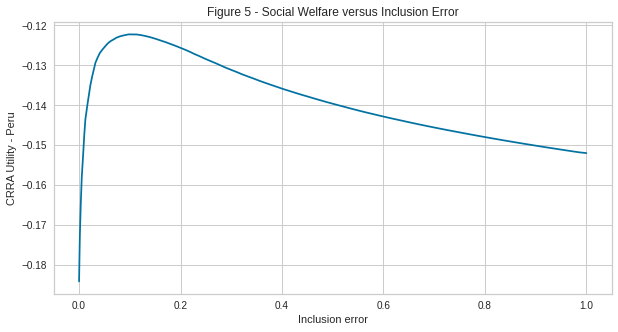

In [ ]:
plt.plot(INC_ERR_TBFMS,CRRA_TBFMS)
plt.xlabel('Inclusion error')
plt.ylabel('CRRA Utility - Peru')
plt.title('Figure 5 - Social Welfare versus Inclusion Error')
plt.show()

In [ ]:
input['expY']=np.exp(input['y'])

input.head()

,lnpercapitaconsumption,d_fuel_other,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_other,d_water_river,d_water_well,d_water_truck,d_water_pylon,d_water_outside,d_water_inside,d_drain_none,d_drain_river,d_drain_cesspool,d_drain_septic,d_drain_outside,d_drain_inside,d_wall_other,d_wall_woodmat,d_wall_stonemud,d_wall_quincha,d_wall_tapia,d_wall_adobe,d_wall_stonecement,d_wall_brickcement,d_roof_other,d_roof_straw,d_roof_mat,d_roof_platecane,d_roof_tile,d_roof_wood,d_roof_concrete,d_floor_other,d_floor_earth,d_floor_cement,d_floor_wood,...,d_h_educ_none,d_h_educ_pre,d_h_educ_prim,d_h_educ_sec,d_h_educ_higher_nouni,d_h_educ_higher_uni,d_h_educ_post,d_max_educ_none,d_max_educ_prim,d_max_educ_sec,d_max_educ_higher_nouni,d_max_educ_higher_uni,d_insurance_0,d_insurance_1,d_insurance_2,d_insurance_3,d_insurance_4plus,d_crowd_lessthan1,d_crowd_1to2,d_crowd_2to4,d_crowd_4to6,d_crowd_6plus,d_lux_0,d_lux_1,d_lux_2,d_lux_3,d_lux_4,d_lux_5,training,percapitaconsumption,poor,h_hhsize,id_for_matlab,hhid,lncaphat_OLS,percapitahat_OLS,y,incl_c,incl_error_normal,expY
0,5.352,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1,0,0,0,0,1,0,0,0,0,1.000,0.000,0.000,0.000,0.000,1,0,0,0,0,0,0,211.000,0,1,1,233710511,5.246,284.424,5.228,1,1,186.443
1,5.769,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0,0,1,0,0,0,0,0,1,0,0.000,1.000,0.000,0.000,0.000,0,0,0,1,0,0,0,320.139,0,3,2,295508011,6.129,522.884,6.065,1,1,430.559
2,5.968,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0,0,0,0,1,0,0,0,0,1,1.000,0.000,0.000,0.000,0.000,0,0,0,1,0,0,0,390.832,0,4,3,257600211,6.666,878.496,6.652,1,1,774.449
3,5.655,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0,0,1,0,0,1,0,0,0,0,0.000,0.000,1.000,0.000,0.000,1,0,0,0,0,0,0,285.602,1,9,4,198104311,6.088,567.471,6.025,1,0,413.765
4,4.771,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0,0,1,0,0,0,0,0,0,1,0.000,1.000,0.000,0.000,0.000,1,0,0,0,0,0,0,118.071,1,8,5,24805311,5.008,115.493,4.945,1,0,140.539


In [ ]:
# export results

#“id_for_matlab”, “hhid”, “training”, “lnpercapitaconsumption “, “groupprediction”

input.to_csv('group_predictions.csv', columns=['id_for_matlab','hhid','training','lnpercapitaconsumption','y','expY'])
!cp group_predictions.csv "drive/My Drive/"



## Conclusion
As previously mentioned, we tested six seperate models and used the three best performing models: GBoost, XGBoost, Gradient Boost. However, the results could still be improved by using an ensemble learner, which took the average prediction of all three models. This approach achieved the best results. 

With the results from our ensemble learner and the CRRA-utility function we were able to replicate Figure 5 from the R. Hanna and B. A. Olken paper.